<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Bayesian Logistic Regression - Metropolis-Hastings</h1>



## 1. Aims
<div class="alert alert-info">
<ul> 
<li> To implement the MH algorithm.
<li> To use it to compute classification probabilities.
</ul>
</div>

## 2. Metropolis-Hastings
<div class="alert alert-info">
In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture.
Use the binary classification data `binaryclass2.mat` and the function `laplacecomp()`. If you
pass this function a 2-dimensional $w$ vector, it will return $g(w; X, t, \sigma^2)$ and $log(g(w; X, t, \sigma^2))$.
(Remember that $g(w; X, t, \sigma^2) \propto p(w|X, t, \sigma^2)$, the posterior density of interest.)
<br><br>
Make sure `laplacecomp()` works by passing it some different $w$ vectors ($w$ needs to have
dimension 2×1).
</div>

In [1]:
import scipy.io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('binaryclass2.mat')

In [2]:
X = mat['X']
t = mat['t']

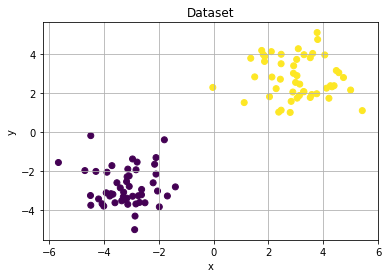

In [3]:
plt.scatter(X[:,0], X[:,1], c=t)
plt.title("Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [4]:
def laplacecomp(w,X,t):
    """This function computes g and log(g) for the laplace model introduced in the lecture."""
    w = np.array(w)
    X = np.array(X)
    t = np.array(t)
    ss = 10 # Prior variance (sigma squared)
    # Evaluate log prior
    log_g = -(1/(2*ss))*w.T.dot(w)
    # Compute P
    P = 1/(1+np.exp(-X.dot(w)))
    log_l = np.sum(t*np.log(P) + (1-t)*(np.log(1-P)))
    log_g = log_g + log_l
    g = np.exp(log_g)
    return g[0][0], log_g[0][0]

<div class="alert alert-info">

Implement the MH algorithm (see the flowchart in the slides). 
<br>
You might find it safest to work with $log(g)$ – the ratio then becomes a subtraction that must then be exponentiated. This has more numerical stability, especially when $w$ isn’t very good. You can start with any value of $w$. E.g., $w = randn(2,1)$. Also, use a Gaussian proposal: For example: $wp = randn(2,1)*0.5+w$ where $w$ is the current sample and $wp$ is the proposal and the Gaussian has standard deviation $0.5$ (set this as you please).
</div>

In [5]:
def MH(X, t, numSamples):
    w_s = list()
    w = np.random.randn(2, 1)
    w_s.append(w)
    Sigma_p = np.array([[0.5, 0], [0, 0.5]])
    for s in range(numSamples):
        w = w_s[s-1]
        wp = np.random.randn(2, 1).T.dot(Sigma_p).T + w # N(mu, sigma)
        _, log_g_wp = laplacecomp(wp, X, t)
        log_p_w = stats.multivariate_normal.pdf(w.reshape(2), mean=wp.reshape(2), cov=Sigma_p)
        _, log_g_w = laplacecomp(w, X, t)
        log_p_wp = stats.multivariate_normal.pdf(wp.reshape(2), mean=w.reshape(2), cov=Sigma_p)
        log_r = log_g_wp - log_g_w
        r = np.exp(log_r)
        if r >= 1:
            w_s.append(wp) # accept
        else:
            u = np.random.normal(0, 1)
            if u <= r:
                w_s.append(wp) # accept
            else:
                w_s.append(w) # reject
    w_s = np.array(w_s).reshape(-1,2)
    return w_s
    

In [7]:
numSamples = 10000
w_samples = MH(X,t, numSamples)

<div class="alert alert-success">
Let's see the distribution of $w$
</div>

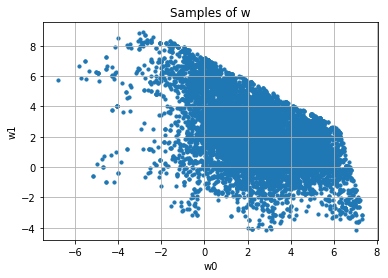

In [8]:
plt.scatter(w_samples[:,0], w_samples[:,1], s=10)
plt.title("Samples of w")
plt.xlabel("w0")
plt.ylabel("w1")
plt.grid()
plt.show()

<div class="alert alert-info">
Compute the probability $P (t_{new} = 1 | x_{new} , X, t)$ when $x_{new} = [2,-4]^T$ . 
<br>
Hint – compute the probability for each value of $w$ using:
$$ \dfrac{1}{1+\exp(-w^T x_{new})} $$
</div>

In [9]:
def predict(samples, x_new):
    p = 0
    for w in samples:
        p += 1/(1 + np.exp(-w.T.dot(x_new))) / len(samples)
    return p

In [10]:
x_new = np.array([2,-4])
predict(w_samples, x_new)

0.38477226848464585

<div class="alert alert-success">
Let's try to see the contours.
</div>

In [11]:
x1min, x1max, x1step = (-6, 6.5, 0.5)
x2min, x2max, x2step = (-6, 6.5, 0.5)
x1_range = np.arange(x1min, x1max, x1step)
x2_range = np.arange(x2min, x2max, x2step)
p = []
for x2 in x1_range:
    p_x = []
    for x1 in x2_range:
        x_new = np.array([x1, x2])
        p_x.append(predict(w_samples, x_new))
    p.append(p_x)

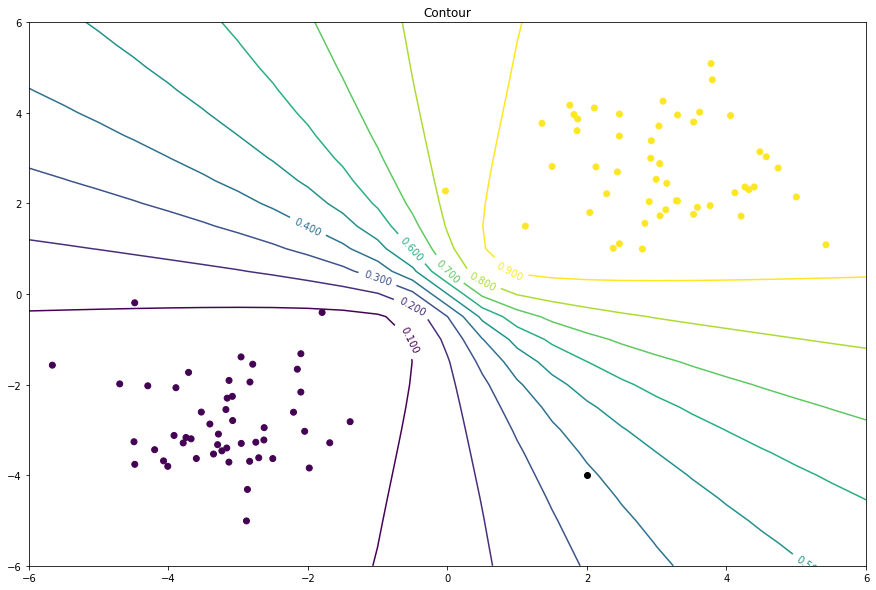

In [14]:
plt.figure(figsize=(15,10))
numLines = 9
CS = plt.contour(x1_range, x2_range, p, numLines)
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(X[:,0], X[:,1], c=t)
plt.scatter(2, -4, c='k')
plt.title('Contour')
plt.show()

<div class="alert alert-success">
In black the test point we predicted with probability ~0.38 of belonging to class 1 (yellow). By looking at the contour lines it is between 0.3 and 0.4, closer to 0.4, which is what we expected.
</div>